<a href="https://colab.research.google.com/github/FKz11/Neural_Network/blob/main/lesson_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lesson-7

## 1. Сделайте краткий обзор любой статьи посвященной тому или иному алгоритму для object detection.

## SSD: Single Shot MultiBox Detector

Задача детектирование обьета на изображении включает в себя 2 задачи: классификация обьекта и локализация его (регрессия).

Архитектура SSD, как и You Only Look Once (YOLO), основанны на одновременном решении задач классификации и локализации, что следует из их названий: Single Shot и Only Look Once, за счёт этого они выигрывают в скорости.

Метрики SSD: 59 FPS on a Nvidia Titan X and for 512 × 512 input, 74.3% mAP

Схема модели:

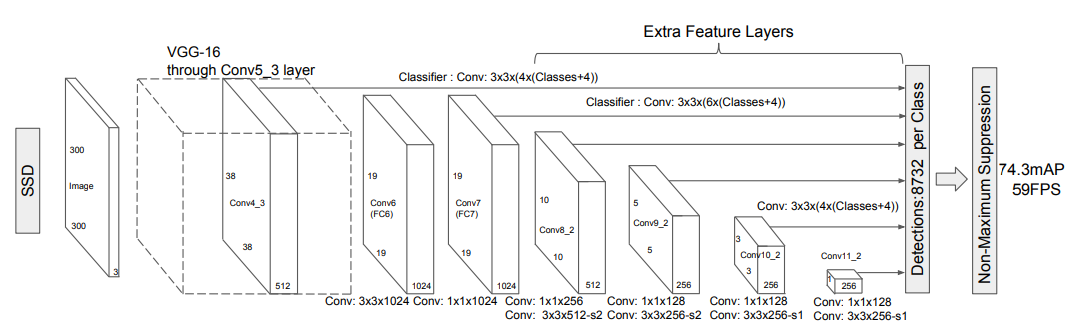

Модель находит 8732 boxs для каждого класса.

Здесь Non-Maximum Suppression, это алгоритм, который одному обьекту из множества positive box ставит в соответствие один box с наибольшим Intersection over Union (IoU). IoU это метрика которая показывает отношение пересечения boxs (Intersection) и обьеденения boxs (Union): Intersection/Union.

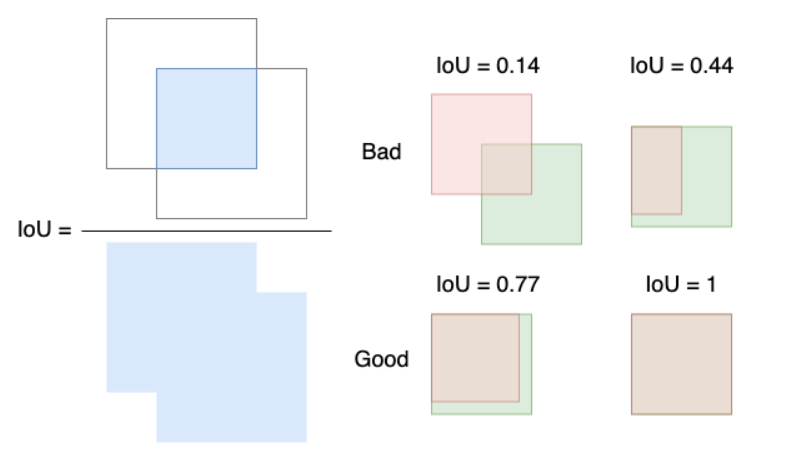

Базовой сетью является VGG16 — сверточная сеть для выделения признаков изображений

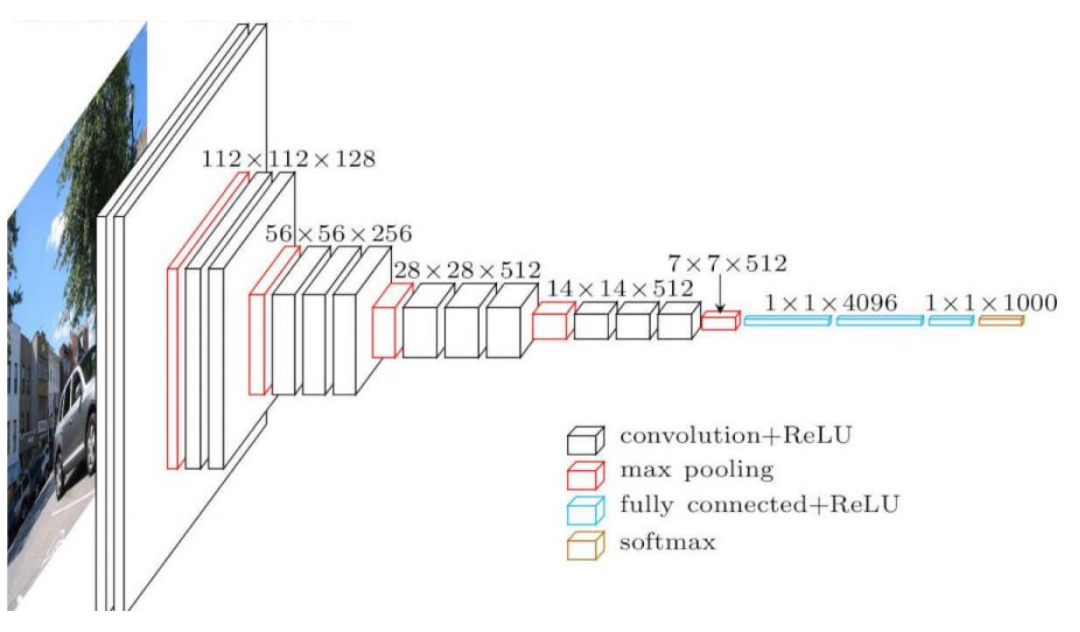

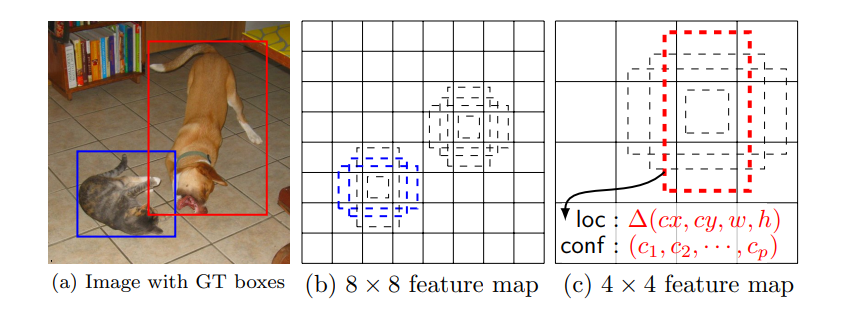

В данной архетиктуре есть base boxs, которые полность покрывают изображение и говорят есть ли в этом боксе искомый обьект. Чем меньше размеров карта признаков, тем больше будет относительно неё base box, а значит, чем меньше карта признаков, тем больший по размеру обьект находит base box и наоборот, чем больше по размеру карта признаков, тем меньший обьект находит base box. Можно сказать, что из-за MaxPool слоёв в VGG16 на маленьких картах признаков будет большая погрешность в локализации, но так как маленькие карты признаков выделяют именно большие обьекты, относительно размеров обьектов погрешность будет не так критична.

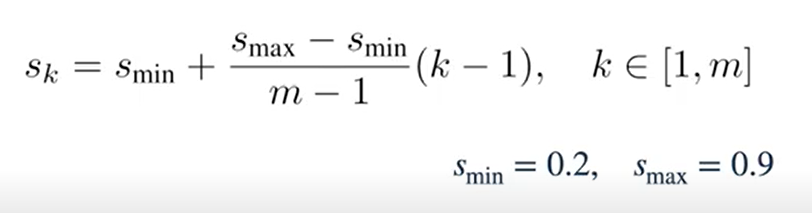

Здесь Sk - это размер base box относительно изображения от 0 до 1. А k - это порядок свёрточных слоёв. Соответственно на 1-ом слое размер будет Smin = 0.2 от размера изображения, а на последнем слое Smax = 0.9 от размера изображения. Это сходится с тем, что было сказано выше, так как с порядком свёрточного слоя мы проходим блоки Conv Conv MaxPool и размер карты признаков уменьшается, соответственно мы находжим обьекты больших размеров.

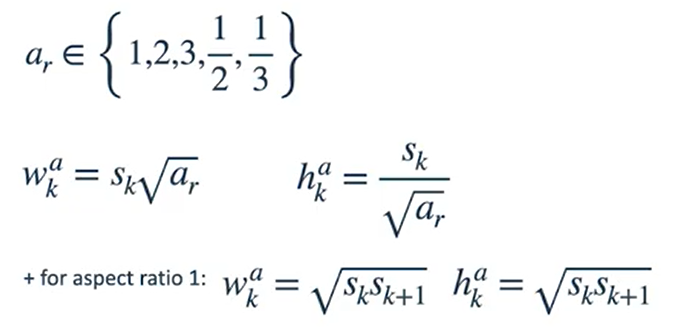

Здесь видно, как задаются 2 квадрата, один размером Sk*Sk, другой со стороной Sqrt(SkxSk+1) и 4 прямоугольника.

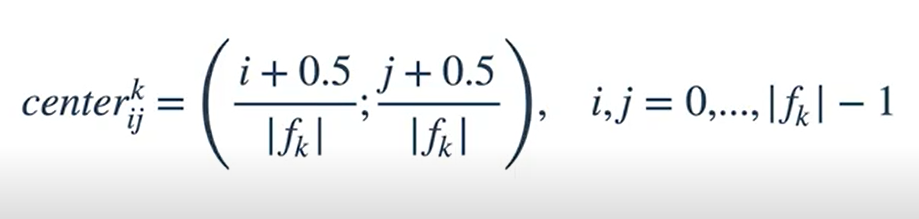

Это координаты центра base boxs. Здесь i,j это номер строки и столбца пикселя который отреагировал на карте признаков fk, |fk| - размер карты признаков. Соответственно коородинаты центра измеряются от 0 до 1.

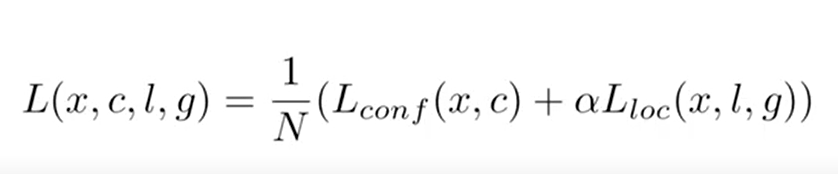

Это целевая функция SSD, здесь Lcon - целевая функция отвечающая за классификацию, Lloc - целевая функция отвечающая за локализацию (причём здесь учавствуют только те boxs, которые не отвечают за фон, так как нам не важна их локализация), N - колличество positive (угаданных) boxs, если их нету L=0, альфа - гиперпараметр, который призван сбалансировать ошибки, потому что если одна ошибка будет гораздо больше другой, то модель станет выполнять только одну из двух задач, ту, по которой ошибка больше, но обычно альфа берут за 1.

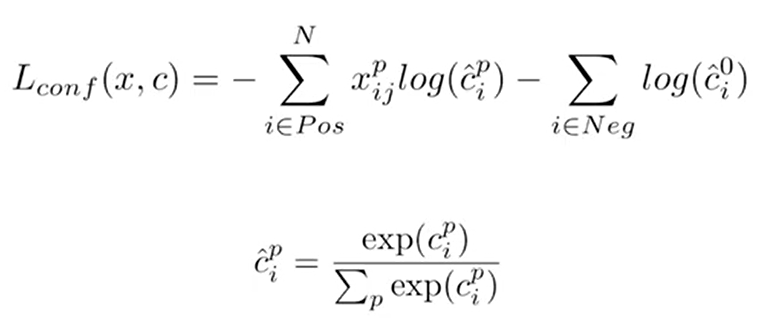

Это целевая функция классификации, здесь используется кросс-энтропия. Xij(p) - это индикатор, был ли i-тый box поставлен в соответствие j-ому оригинальному box, p - класс. 0 - это класс фона. с^ - вектор выхода SSD с функцией активации SoftMax.

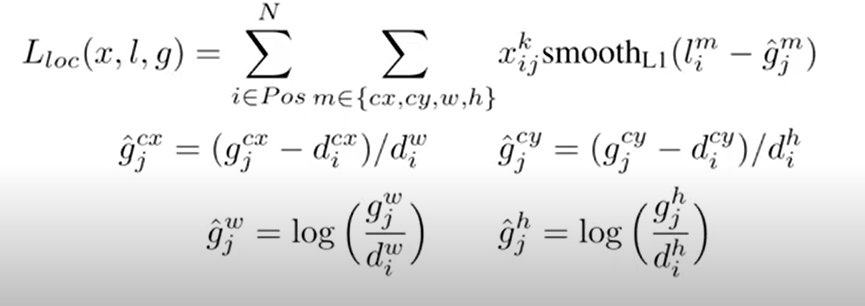

Это целевая функция локализации. Здесь приведены 4 потери: gcx, gcy это потери при нахождении центра box по осям x, y; gw, gh это потери при нахождении размера box по ширине, высоте. Эти потери нормированы и они будут от 0 до 1, так как если центры или размеры были бы еще неправильней, мы бы уже не отнесли box к positive. SmoothL1 - это такая ошибка, которая от -const до +const является L2, а вне этого диапазона является L1. Так же эта функция должна быть непрерывна и дифференцируема. График приведён ниже.

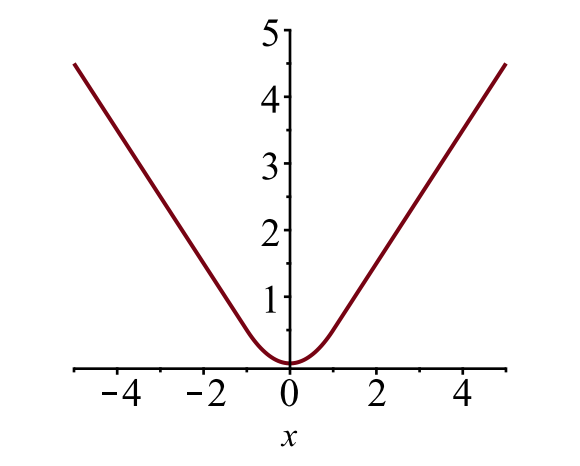

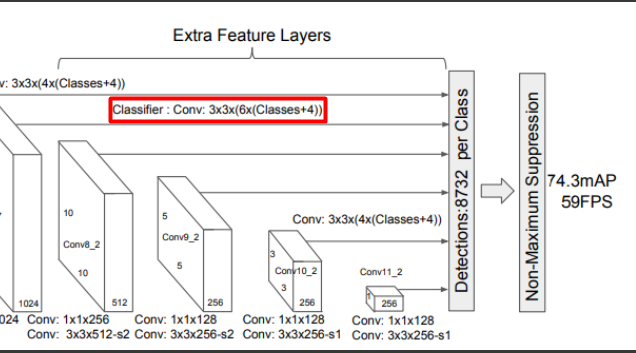

Здесь 3*3 это размер ядра свёртки. 6 - количество base boxs. Classes - количество классов. 4 - это количество ошибок локализации для base boxs: gcx, gcy - потери при нахождении центра box; gw, gh - потери при нахождении размера box. 

Так же при обучении у нас получается несбалансированность классов, так как positive boxs намного меньше, чем negative boxs отвечающих за фон. Поэтому рекомендованно остовлять только такое количество negative boxs, чтобы на 3 negative boxs приходился один positive box. Но остовлять не случайные negative boxs, а те, которые дают наибольшую ошибку, тоесть являются сложными и интересными для обучения, такой подход называется Hard Negative Mining.

Так же можно использовать Data Augmentation. При этом рекомендованно вырезать из картинки обьект, так, чтобы размер нового изображения был 0.1, 0.3, 0.5, 0.7, 0.9 от старого.

В понимании помогла видео-лекция: https://www.youtube.com/watch?v=F5nMyPtCOdM

## 2. Запустите детектор (ssdMobile_v2 или faster_rcnn, или любой другой детектор) для своей картинки и попробуйте найти 10 объектов, 100 объектов.

In [1]:
#Импорт всего

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

import cv2 as cv

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
"/content/drive/MyDrive/Colab Notebooks/airline-passengers.csv"

'/content/drive/MyDrive/Colab Notebooks/airline-passengers.csv'

### Загрузка детектора Faster R-CNN

In [4]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


### Формирование и обработка результатов детектирования

In [5]:
# выводит картинку
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

### Обработка изображения для передачи в детектор:

#### Формируем тензор

In [6]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

#### Выполняем детектор

In [9]:
def run_detector(detector, path, max_boxes=20):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  #print(result['detection_scores'])
  result = {key:value.numpy() for key,value in result.items()} 

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=max_boxes)

  display_image(image_with_boxes)
  return result

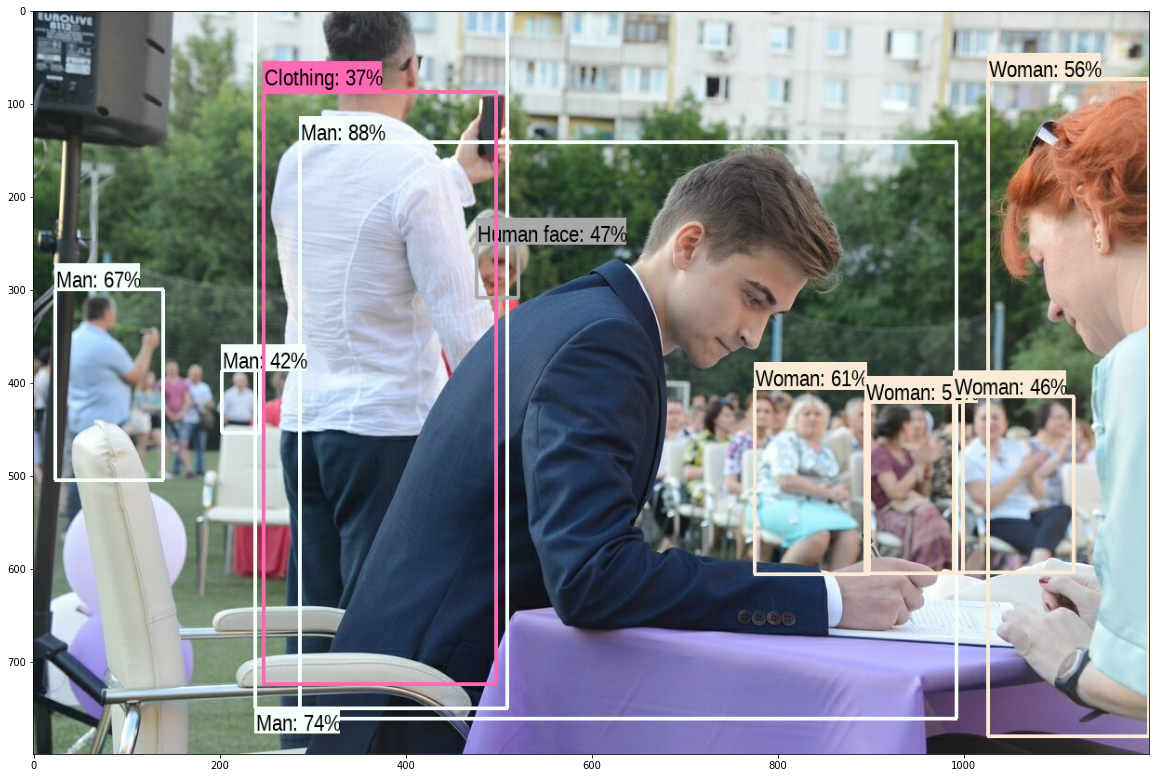

In [11]:
result = run_detector(detector, "/content/drive/MyDrive/Colab Notebooks/me.jpg", max_boxes=10)

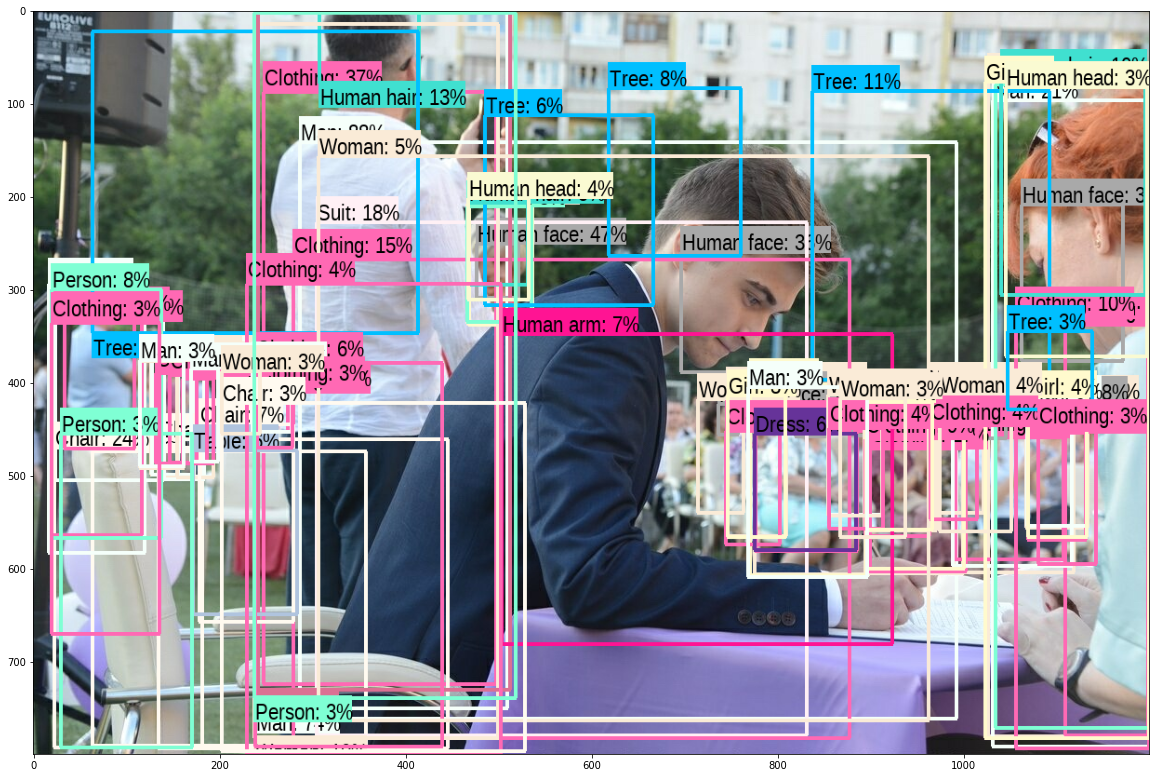

In [12]:
result = run_detector(detector, "/content/drive/MyDrive/Colab Notebooks/me.jpg", max_boxes=100)

Видно, что модель Faster R-CNN отлично справляется с довольно сложной фотографией, на которой множество пересекающихся обьектов с разной четкостью отображения.